<table style="float:left; border:none">
   <tr style="border:none">
       <td style="border:none">
           <a href="https://bokeh.org/">     
           </a>    
       </td>
       <td style="border:none">
           <h1>Uncertainty Spillover</h1>
       </td>
   </tr>
</table>

<div style="float:right;"><h2>05. Jump damage</h2></div>

In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from solver_1d import false_transient_one_iteration_python
from supportfunctions import PDESolver_2d, finiteDiff
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one
from solver_jump import approach_one_100, solve_smooth_unreveal, generate_weight, solve_smooth_100
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams["lines.linewidth"] = 2.5
mpl.rcParams["legend.frameon"] = False

In [30]:
# parameters
δ = 0.01
η = 0.032
μ = 1.86/1000
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
σy = 1.2*μ
ς = 0.1
# damage function
# ȳ = 1.9
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.array([0, 2*0.0197, 2*0.3853])
# γ3_list = np.linspace(0,1/3, 40)
# y grid
numy_bar = 100
y_min = 0
y_max = 4
# hy = (ȳ - y_min)/numy_bar
hy=0.02
y_grid = np.arange(y_min, y_max+hy, hy)

In [31]:
# capital parameters
invkap = 0.09
α = 0.115
αₖ = - 0.043
σₖ = 0.0085
κ = 6.667
k0 = 85/α

In [32]:
n_temp = 16
n_carb = 9
n_θ = len(θ_list)
θ_mat = θ_list.reshape(n_temp, n_carb)
θtemp_list = np.average(θ_mat, axis=1)
θcarb_list = np.average(θ_mat, axis=0)

# Jump model of damages
Intensity function:
$$
\mathcal{I}(y) = \begin{cases}
(\frac{1}{\sqrt{2\pi} \varsigma})\exp\left[- \frac{(y - \bar y)^2}{2\varsigma^2}\right], \quad y \leqslant \bar y\\
(\frac{1}{\sqrt{2\pi}\varsigma}), \quad y > \bar y
\end{cases}
$$

HJB
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{\pi^d} &- \delta \phi(y) + \eta \log\tilde e \\
    & +  \frac{d\phi}{dy}\sum_i \pi_i^a\theta_i \tilde e  + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2 + \frac{1}{2} \frac{(\eta - 1)}{\delta} \gamma_2 (\tilde e)^2 |\sigma_y|^2\\
& + \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y) \tilde e \sum_i \pi_i^a\theta_i + \mathcal{I}(y)\sum_j \pi^d_j \left[\phi_j(y) - \phi(y) \right] \\
&  + \textbf{relative entropy}
\end{aligned}
$$
## Approach one:
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{g_j} &- \delta \phi(y) +  \eta \log\tilde e + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2  + \frac{\xi_m}{2} h'h\\
& + [ \frac{d\phi}{dy}    + \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y)]\cdot \tilde e \sigma_y h +\frac{1}{2}\frac{ (\eta - 1)}{\delta} \gamma_2 (\tilde e)^2 |\sigma_y|^2\\
& + \sum_i \pi_i^c \frac{d\phi}{dy} \theta_i \tilde e  + \sum_i \pi_i^c \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y) \tilde e \theta_i + \xi_a \sum_i \hat\pi^c_i(\log \pi^c_i - \log \hat\pi^c_i)\\
&  + \mathcal{I}(y)\sum_j\hat\pi_j^d g_j\left[\phi_j(y) - \phi(y) \right]  + \xi_m \mathcal{I}(y) \sum_j \hat\pi_j^d [1 - g_j + g_j \log g_j]
\end{aligned}
$$
The optimal $g_j$:
$$
g_j^* = \exp\{\frac{1}{\xi_m}\left( \phi(y) - \phi_j(y)\right)\}
$$
Plug back in
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{g_j} &- \delta \phi(y) + \eta \log\tilde e + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2 + \frac{1}{2}\frac{(\eta -1)}{\delta}\gamma_2(\tilde e)^2 |\sigma_y|^2\\
& + \sum_i \pi_i^c \left[\frac{d\phi}{dy}  + \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y)\right] \tilde e \theta_i + \xi_a \sum_i \hat\pi^c_i(\log \pi^c_i - \log \hat\pi^c_i) \\
&  +  \xi_m \mathcal{I}(y) \sum_j \hat\pi_j^d [1 - g_j^* ]
\end{aligned}
$$
Intensity altered to be $\iota^*(y) \mathcal{I} (y)$ where:
$$
\iota^*(y)  = \sum_j \hat\pi_j g_j^* 
$$
Distorted probability:
$$
\pi^*_j  = \frac{\exp\left(-\frac{1}{\xi_m} [\phi_j(y) - \phi(y)] \right) \hat\pi_j}{\iota^*(y)}
$$

In [33]:
def simulate_jump(y_grid, solu, ME,  θ_list, y_start=1, T=100, dt=1):
    ems = solu["ems"]
    πᶜ = solu["πc"]
    πᵈ = solu["πd"]
    ι = solu["ι"]
    h = solu["h"]
    periods = int(T/dt)
    et = np.zeros(periods)
    yt = np.zeros(periods)
    πᶜt = np.zeros((periods, len(θ_list)))
    πᵈt = np.zeros((periods, len(πᵈ)))
    ιt = np.zeros(periods)
    ht = np.zeros(periods)
    if ME is not None:
        me_t = np.zeros(periods)
    # interpolate
    get_πᵈ = interpolate.interp1d(y_grid, πᵈ)
    get_πᶜ = interpolate.interp1d(y_grid, πᶜ)
#     y = np.mean(θ_list)*290
    y = y_start
    for t in range(periods):
        if y > np.max(y_grid):
            break
        else:
            ems_point = np.interp(y, y_grid, ems)
            πᵈ_list = get_πᵈ(y)
            πᶜ_list = get_πᶜ(y)
            ι_point = np.interp(y, y_grid, ι)
            h_point = np.interp(y, y_grid, h)
            if ME is not None:
                me_point = np.interp(y, y_grid, ME)
                me_t[t] = me_point
            et[t] = ems_point
            πᵈt[t] = πᵈ_list
            πᶜt[t] = πᶜ_list
            ιt[t] = ι_point
            ht[t] = h_point
            yt[t] = y
            dy = ems_point*np.mean(θ_list)*dt
            y = dy + y
    if ME is not None:
        return yt, et, πᵈt, πᶜt, ιt, ht, me_t
    else:
        return yt, et, πᵈt, πᶜt, ιt, ht

In [34]:
# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt
def simulate_scc(invkap, αₖ,  σₖ, κ, k0, MEt, T=100, dt=1):
    Kt = simulate_logkapital(invkap, αₖ, σₖ, κ,  k0)
    MCt = (1-η)/((α - invkap)*np.exp(Kt))
    SCCt = MEt/MCt*1000
    return SCCt

In [35]:
logKt = simulate_logkapital(invkap, αₖ,  σₖ, κ, k0,)

In [38]:
ȳ = 2
ξa = 1000*100
ξw = 1000*100
ξp = 1000*100
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one_100(y_grid, numy_bar, args, ϵ = 2, max_iter=2000)
yt_base, et_base, πᵈt, πᶜt, ιt, ht = simulate_jump(y_grid[:numy_bar+1], solu, None, θ_list)

episode: 734,	 ode error: 9.510157983862177e-05,	 ft error: 9.783096999171903e-09
episode: 2000,	 ode error: 0.00024386866070565116,	 ft error: 5.4597914284304494e-05
episode: 816,	 ode error: 0.0010822676145664052,	 ft error: 9.219412788752379e-09
episode: 2000,	 ode error: 0.0005636831208749443,	 ft error: 1.84998634045197e-06


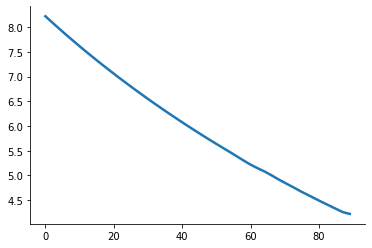

In [39]:
plt.plot(et_base[et_base>0])

# Decompose  for no jump version

# SCC uncertainty decomposition: pre jump

First order condition for $\tilde e$

$$
    \left( \frac{d^2\phi(y)}{dy^2} + \frac{(\eta-1)}{\delta}\cdot\gamma_2  \right)|\sigma_y|^2\tilde e + \sum_j \pi^c_j \left[\frac{d\phi(y)}{dy} + \frac{(\eta - 1)}{\delta}(\gamma_1 + \gamma_2 y)\right]\theta_j  + \frac{\eta}{\tilde e} = 0 \tag{$\ast$}
$$

Call solution $\tilde e^* $. Now solve:
$$
\begin{aligned}
0 =  & - \delta \color{red}{\phi(y)}+ \eta \log\tilde e^* + \frac{1}{2} \color{red}{ \frac{d^2 \phi}{dy^2}}\cdot(\tilde e^*)^2 |\sigma_y|^2 + \frac{1}{2}\frac{(\eta -1)}{\delta}\gamma_2(\tilde e^*)^2 |\sigma_y|^2\\
& + \left[\color{red}{\frac{d\phi}{dy}}  + \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y)\right] \tilde e^* \sum_i \pi_i^c \theta_i
\end{aligned}
$$

In [26]:
def plot_together(et, θ_list, ht, πᶜt, πᵈt, MEt, dmg_weight):
    y_grid_cap = y_grid[:numy_bar+1]
    πᶜo = πᶜo = np.ones(len(θ_list))/len(θ_list)
    # plot
    fig,((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12,8))
    fig.tight_layout(pad=5)
    # plot 1
    if np.count_nonzero(dmg_weight) > 2:
        ax1.plot(πᵈt[:,-1], label="extreme damage", color="C2")
    ax1.plot(πᵈt[:,1], label="high damage", color="C3")
    ax1.plot(πᵈt[:,0], label="low", color="C0")
    ax1.legend(frameon=False)
    ax1.set_xlabel('Years')
    ax1.set_ylim(0,1)
    ax1.set_xlim(left=0)
    ax1.set_title('distorted probability of damage')
    # plot 2
    bins = np.linspace(1,3,14)
    ax2.hist(θ_list*1000, density=True, color='tab:red', bins=bins, histtype='bar', ec='gray', alpha=.5, )
    ax2.hist((θ_list+σy*ht[49])*1000, weights=πᶜt[49], density=True, color='tab:blue',bins=bins, histtype='bar', ec='gray', alpha=.5,)
    ax2.set_title('mean difference: {:.4f}'.format((θ_list@(πᶜt[49]-πᶜo)+σy*ht[49])*1000))
    ax2.set_xlabel('Climate sensitivity, year 50')
    ax2.set_xlim(0.8,3)
    # plot 3
    ax3.plot(et[et_base>0],label='distorted', color="C3")
    ax3.plot(et_base[et_base>0], label="baseline", color="C0")
    ax3.legend(frameon=False)
    ax3.set_xlabel('Years')
    ax3.set_ylim(bottom=0)
    ax3.set_xlim(left=0)
    ax3.set_title('emission')
    # plot 4
    SCCt_base, _ = simulate_scc(invkap, αₖ,  σₖ, κ, k0, MEt)
    SCCt_distorted, _ = simulate_scc(invkap, αₖ,  σₖ, κ, k0, δ*η/et)
#     ax4.plot((δ*η/et[et>0])/MC[et>0]*1000, label="total", color="C3")
    ax4.plot(SCCt_distorted, label="total", color="C3")
#     ax4.plot((ME/MC)[et>0]*1000, label="baseline", color="C0")
    ax4.plot(SCCt_distorted - SCCt_base, label="baseline", color="C0")
    ax4.legend(frameon=False)
    ax4.set_xlabel('Years')
    ax4.set_ylim(bottom=0)
    ax4.set_xlim(left=0)
    ax4.set_title('social cost of carbon')
    
    return fig, ((ax1, ax2), (ax3, ax4))

In [ ]:
ξa = 100_000
ξw = 100_000
ξp = 100_000
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one_100(y_grid, numy_bar, args, ϵ=2, max_iter=2000)

In [44]:
yt_bb, et_bb, πᵈt, πᶜt, ιt, ht = simulate_jump(y_grid[:numy_bar+1], solu, None, θ_list, y_start=1.1)
# yt_bbw, et_bbw, πᵈt, πᶜt, ιt, ht = simulate_jump_ems(y_grid[:numy_bar+1], solu, None, θ_list)

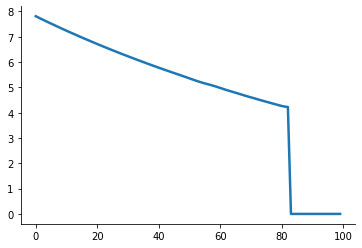

In [45]:
plt.plot(et_bb)

In [47]:
ξa = 100_000
ξw = 0.3
ξp = 5
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one_100(y_grid, numy_bar, args, max_iter=5_000)
yt_3, et_3, πᵈt, πᶜt_3, ιt, ht_3 = simulate_jump(y_grid[:numy_bar+1], solu, None, θ_list, y_start=1.1)
# yt_3w, et_3w, πᵈt, πᶜt_3, ιt, ht_3w = simulate_jump_ems(y_grid[:numy_bar+1], solu, None, θ_list)

episode: 5000,	 ode error: 0.0006080189295310512,	 ft error: 5.7292277159485635e-05
episode: 5000,	 ode error: 0.00023656570782026182,	 ft error: 8.516285446698765e-05
episode: 5000,	 ode error: 0.0009873530913568787,	 ft error: 3.187842878560332e-08
episode: 1474,	 ode error: 0.0006520754051868409,	 ft error: 9.84817560834017e-09


In [48]:
# adding equal version 1 
ξa = 100000
ξw = 0.3
ξp = 0.3
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one_100(y_grid, numy_bar, args, ϵ=2, max_iter=5_000)
yt_e1, et_e1, πᵈt, πᶜt, ιt, ht_e1 = simulate_jump(y_grid[:numy_bar+1], solu, None, θ_list, y_start=1.1)
# yt_e1w, et_e1w, πᵈt, πᶜt, ιt, ht_e1w = simulate_jump_ems(y_grid[:numy_bar+1], solu, None, θ_list)

episode: 5000,	 ode error: 8.370381705768981e-05,	 ft error: 2.0938360984601445e-05
episode: 765,	 ode error: 0.0002838397833124645,	 ft error: 9.472502116025794e-09
episode: 816,	 ode error: 0.0009680913354023629,	 ft error: 9.830490199647102e-09
episode: 5000,	 ode error: 0.0018796842983399382,	 ft error: 8.413117119632219e-07


In [49]:
# adding equal version 2
ξa = 100_000
ξw = 5
ξp = 5
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one_100(y_grid, numy_bar, args, ϵ=2, max_iter=2_000)
yt_e2, et_e2, πᵈt, πᶜt, ιt, ht_e2 = simulate_jump(y_grid[:numy_bar+1], solu, None, θ_list, y_start=1.1)
# yt_e2w, et_e2w, πᵈt, πᶜt, ιt, ht_e2w = simulate_jump_ems(y_grid[:numy_bar+1], solu, None, θ_list)

episode: 2000,	 ode error: 5.859597136723127e-05,	 ft error: 3.261688590328049e-07
episode: 2000,	 ode error: 0.00024191317547733737,	 ft error: 5.018886736229966e-05
episode: 814,	 ode error: 0.0010729131573266638,	 ft error: 9.986444560183827e-09
episode: 2000,	 ode error: 0.0007890376141928349,	 ft error: 1.1616897949040528e-05


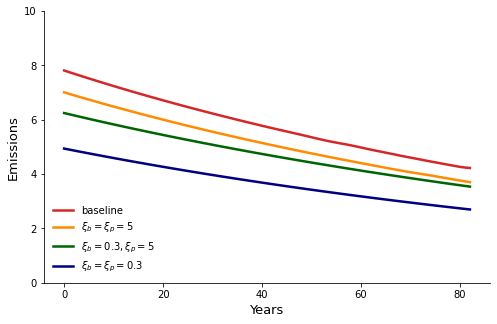

In [56]:
#
years = np.arange(0,100)
fig = plt.figure(figsize=(8,5))
plt.plot(years[et_bb>0], et_bb[et_bb>0], label="baseline", color="tab:red")
plt.plot(years[et_bb>0], et_e2[et_bb>0], label="$ξ_b = ξ_p = 5$", color="darkorange")
# plt.plot(et_brownian, label="brownian robust, jump robust", color="tab:blue")
# plt.plot(et_smooth, label="smooth ambiguity, jump robust", color="darkgreen")
plt.plot(years[et_bb>0], et_3[et_bb>0], label="$ξ_b =0.3,  ξ_p = 5$", color="darkgreen")
plt.plot(years[et_bb>0], et_e1[et_bb>0], label="$ξ_b = ξ_p = 0.3$" , color="navy")

# plt.plot(et, label="with drift term + jump robust")
plt.legend(frameon=False, loc=3)
plt.ylim(0,10)
# plt.xlim(right=95)
# plt.xticks(np.arange(0, 91, 10))
plt.ylabel('Emissions', fontsize=13)
plt.xlabel('Years', fontsize=13)
plt.savefig("../figures/emission_three.pdf")
# plt.savefig("./paper_plots/emission_five.png", facecolor="w", edgecolor="w", bbox_inches="tight")

<ipython-input-58-c37a92bf2ecd>:8: RuntimeWarning: divide by zero encountered in log
  plt.plot(years, np.log(1000) + np.log(C0)  - (yt_e2*γ1 + γ2/2*yt_e2**2) -np.log(et_e2) + np.log(η) - np.log(1- η), label="$ξ_b = ξ_p = 5$", color="darkorange")
<ipython-input-58-c37a92bf2ecd>:9: RuntimeWarning: divide by zero encountered in log
  plt.plot(years, np.log(1000) + np.log(C0)  - (yt_bb*γ1 + γ2/2*yt_bb**2) -np.log(et_bb) + np.log(η) - np.log(1- η), label="baseline", color="tab:red")


Text(0.5, 0, 'Years')

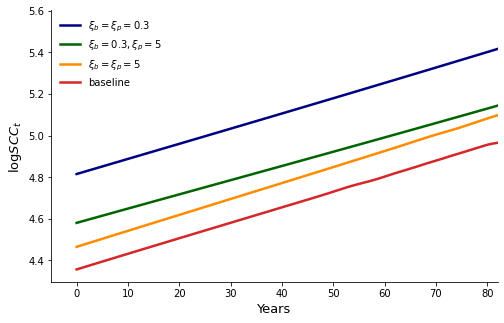

In [58]:
#
fig = plt.figure(figsize=(8,5))
x_max = np.max(np.where(et_bb>0))
C0 = (α - invkap)*k0
plt.plot(years, np.log(1000) + np.log(C0)  - (yt_e1*γ1 + γ2/2*yt_e1**2) -np.log(et_e1) + np.log(η) - np.log(1- η), label="$ξ_b = ξ_p = 0.3$", color="navy")
plt.plot(years, np.log(1000) + np.log(C0)  - (yt_3*γ1 + γ2/2*yt_3**2) -np.log(et_3) + np.log(η) - np.log(1- η), label="$ξ_b =0.3, ξ_p = 5$", color="darkgreen")
# plt.plot( np.log(1000) - np.log(et) + np.log(η) - np.log(1 -η), label="with drift term + jump robust")
plt.plot(years, np.log(1000) + np.log(C0)  - (yt_e2*γ1 + γ2/2*yt_e2**2) -np.log(et_e2) + np.log(η) - np.log(1- η), label="$ξ_b = ξ_p = 5$", color="darkorange")
plt.plot(years, np.log(1000) + np.log(C0)  - (yt_bb*γ1 + γ2/2*yt_bb**2) -np.log(et_bb) + np.log(η) - np.log(1- η), label="baseline", color="tab:red")
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)
# plt.legend(frameon=False)
# plt.ylim(0)
# plt.xticks(np.arange(0,91,10))
plt.xlim(right=x_max)
plt.ylabel('$\log SCC_t$', fontsize=13)
plt.xlabel('Years', fontsize=13)
# plt.title('$ \log(1000) -\log{\mathcal{E}_t} + \log \eta  - \log (1 - \eta)$')
# plt.savefig("../figures/logscc.pdf")
# plt.savefig("./paper_plots/logscc_five.png", facecolor="w", edgecolor="w", bbox_inches="tight")